# 图像增强

* 图像增广（image augmentation）技术通过对训练图像做一系列的随机改变，来产生相似但又不同的训练样本，从而扩大训练数据集的规模。

In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
%matplotlib inline
import gluonbook as gb
import mxnet as mx
from mxnet import autograd, gluon, image, init, nd
from mxnet.gluon import data as gdata, loss as gloss, utils as gutils
import sys
from time import time

C:\Users\lenovo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


* 我们来读取一张形状为 400x500的图像作为实验中的样例

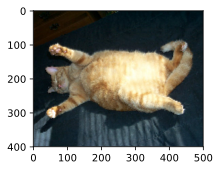

In [3]:
gb.set_figsize()
img = image.imread('../img/cat1.jpg')
gb.plt.imshow(img.asnumpy())

# 下面定义显示图像的函数

In [4]:
def show_images(imgs,num_rows,num_cols,scale = 2):
    figsize = (num_cols * scale,num_rows * scale)
    _,axes = gb.plt.subplots(num_rows,num_cols,figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i*num_cols+j].asnumpy())
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

## 定义调用图像增强的函数

In [5]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

### 翻转和裁剪

* 左右翻转

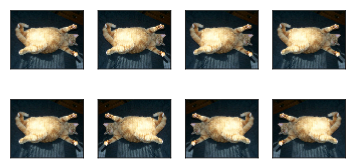

In [6]:
apply(img, gdata.vision.transforms.RandomFlipLeftRight())

* 上下翻转

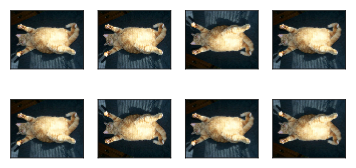

In [7]:
apply(img,gdata.vision.transforms.RandomFlipTopBottom())

* 随机裁剪

In [8]:
shape_aug = gdata.vision.transforms.RandomResizedCrop((200,200),scale=(0.1,1),ratio=(0.5,2))

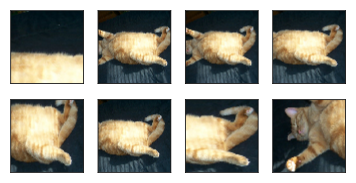

In [9]:
apply(img, shape_aug)

* 变换颜色

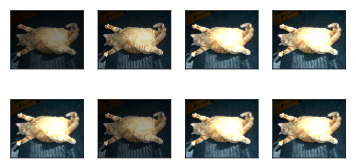

In [10]:
apply(img, gdata.vision.transforms.RandomBrightness(0.5))

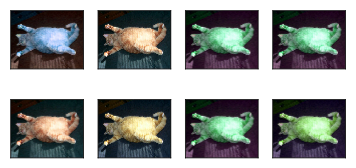

In [11]:
apply(img, gdata.vision.transforms.RandomHue(0.5))

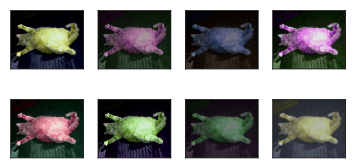

In [12]:
color_aug = gdata.vision.transforms.RandomColorJitter(
brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

## 叠加多个图像增广方法

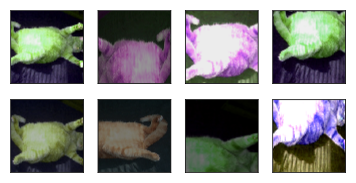

In [13]:
augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.RandomFlipLeftRight(), color_aug, shape_aug])
apply(img, augs)

## 使用图像增广来训练模型


 * 这里使用CIFAR10数据集

In [14]:
CIFAR10_train = gdata.vision.CIFAR10(root='../data/CIFAR10',train=True)
CIFAR10_test = gdata.vision.CIFAR10(root='../data/CIFAR10',train=False)

In [15]:
print(CIFAR10_train[0:32][1])

[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6 4 3 6 6 2 6 3 5 4 0 0 9]


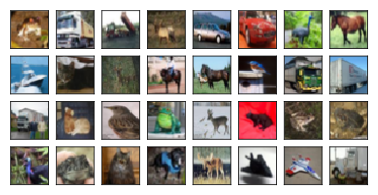

In [16]:
show_images(CIFAR10_train[0:32][0], 4, 8, scale=0.8);

 * 我们通常只把图像增强用在训练上面，测试的时候不进行增强

In [17]:
train_augs = gdata.vision.transforms.Compose([
gdata.vision.transforms.RandomFlipLeftRight(),
gdata.vision.transforms.RandomBrightness(0.5),
gdata.vision.transforms.RandomHue(0.5),
gdata.vision.transforms.RandomColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
gdata.vision.transforms.ToTensor(),
])

test_augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.ToTensor(),
])

* 定义一个函数来读取CIFAR10数据

In [18]:
def load_cifar10(is_train,augs,batch_size):
    return gdata.DataLoader(
    gdata.vision.CIFAR10(root='../data/CIFAR10/',train=is_train).transform_first(augs),batch_size=batch_size,shuffle=is_train,)
    

* 尝试使用所有的GPU训练

In [19]:
def try_all_gpu():
    ctxes = []
    try:
        for i in range(16):
            ctx = mx.gpu(i)
            _ = nd.array([0],ctx=ctx)
            ctxes.append(ctx)
    except mx.base.MXNetError:
        pass
    if not ctxes:
        ctxes = [mx.cpu()]
    return ctxes

In [20]:
def _get_batch(batch,ctx):
    features,labels = batch
    if labels.dtype!= features.dtype:
        labels = labels.astype(features.dtype)
    # 当 ctx 包含多个 GPU 时，划分⼩批量数据样本并复制到各个 GPU 上。
    return (gutils.split_and_load(features, ctx),
    gutils.split_and_load(labels, ctx),
    features.shape[0])
    

* 尝试使用所有GPU来评价模型

In [25]:
def evaluate_accuracy(data_iter,net,ctx=[mx.cpu()]):
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    acc = nd.array([0])
    n = 0
    for batch in data_iter:
        features,labels,_ = _get_batch(batch,ctx)
        for X,y in zip(features,labels):
            y = y.astype('float32')
            acc += (net(X).argmax(axis=1)==y).sum().copyto(mx.cpu())
            n += y.size
        
        acc.wait_to_read()  #同步
    return acc.asscalar()/n
            

### 定义使用多GPU训练的函数

In [26]:
def train(train_iter,test_iter,net,loss,trainer,ctx,num_epochs):
    print('training on',ctx)
    print('mx.Context',mx.Context)
    if isinstance(ctx,mx.Context):
        print('isinstance')
        ctx = [ctx]
    #开始训练
    print('ctx\t',ctx)
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n,m=0.0,0.0,0.0,0.0
        start = time()
        for i,batch in enumerate(train_iter):
            #获取小批量数据
            Xs,ys,batch_size = _get_batch(batch,ctx)
            with autograd.record():
                #前向运算
                y_hats = [net(X) for X in Xs]
                #计算损失函数
                ls = [loss(y_hat,y) for y_hat,y in zip(y_hats,ys)]
            #反向传播
            for l in ls:
                l.backward()
            #记录误差
            train_l_sum += sum([l.sum().asscalar() for l in ls])
            #记录测试准确度
            train_acc_sum += sum([(y_hat.argmax(axis=1)==y).sum().asscalar() for y_hat,y in zip(y_hats,ys)])
            trainer.step(batch_size)
            n+=batch_size
            m+=sum([y.size for y in ys])
        test_acc = evaluate_accuracy(test_iter,net,ctx=ctx)
        print('epoch %d,loss %.4f,train acc %.3f,test acc %.3f time %.1f sec'
             %(epoch+1,train_l_sum/n,train_acc_sum/m,test_acc,time()-start))
            

In [27]:
def train_with_data_aug(train_augs,test_augs,lr=0.001):
    batch_size,ctx,net = 32,try_all_gpu(),gb.resnet18(10)
    net.initialize(init=init.Xavier(),ctx=ctx)
    trainer = gluon.Trainer(net.collect_params(),'adam',{'learning_rate':lr})
    loss = gloss.SoftmaxCrossEntropyLoss()
    train_iter = load_cifar10(True,train_augs,batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs=10)

In [ ]:
train_with_data_aug(train_augs, test_augs)

training on [gpu(0)]
mx.Context <class 'mxnet.context.Context'>
ctx	 [gpu(0)]
epoch 1,loss 1.5069,train acc 0.463,test acc 0.639 time 156.3 sec
epoch 2,loss 0.9191,train acc 0.681,test acc 0.685 time 153.0 sec
epoch 3,loss 0.7385,train acc 0.746,test acc 0.757 time 161.4 sec
epoch 4,loss 0.6291,train acc 0.784,test acc 0.803 time 156.9 sec
epoch 5,loss 0.5420,train acc 0.814,test acc 0.799 time 156.1 sec


In [ ]:
train_with_data_aug(test_augs, test_augs)